In [1]:
import numpy as np
import pandas as pd
import os
import pdb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = "/clusterfs/nilah/ruchir/src/finetuning-enformer/finetuning/data/h5_bins_384_chrom_split/"
enformer_data_dir = "/global/scratch/users/aniketh/enformer_data/"
root_save_dir = "/global/scratch/users/aniketh/finetune-enformer/"
models_dir = "/global/scratch/users/aniketh/finetune-enformer/saved_models/"
test_preds_dir = "/global/scratch/users/aniketh/finetune-enformer/test_preds_final/"
rest_unseen_preds_dir = (
    "/global/scratch/users/aniketh/finetune-enformer/rest_unseen_preds_final/"
)
enformer_test_data_preds_dir = (
    "/global/scratch/users/aniketh/finetune-enformer/enformer_test_data_preds_final/"
)
ISM_preds_dir = "/global/scratch/users/aniketh/finetune-enformer/ISM/"
code_dir = "/global/home/users/aniketh/finetuning-enformer/"
fasta_path = "/clusterfs/nilah/aniketh/hg19/hg19.fa"
malinois_data_path = (
    "/clusterfs/nilah/aniketh/Malinois/all_sequences_variant_effect_data.csv"
)

train_h5_path = os.path.join(data_dir, "train.h5")
val_h5_path = os.path.join(data_dir, "val.h5")
test_h5_path = os.path.join(data_dir, "test.h5")
rest_unseen_h5_path = os.path.join(data_dir, "rest_unseen.h5")

counts_path = os.path.join(
    code_dir, "process_geuvadis_data", "log_tpm", "corrected_log_tpm.annot.csv.gz"
)
gene_class_path = os.path.join(
    code_dir, "finetuning", "data", "h5_bins_384_chrom_split", "gene_class.csv"
)
assert os.path.exists(counts_path) and os.path.exists(gene_class_path)

In [5]:
all_main_run_names = {
    "baseline": "",
    "regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "joint_regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_with_enformer_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {enformer_data_dir} {run_name} {models_dir} --batch_size 1 --lr 0.0005 --weight_decay 0.005 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "finetune_regression_on_enformer_data": "NCCL_P2P_DISABLE=1 python finetuning/finetune_pairwise_regression_model_on_Enformer_training_data.py {enformer_data_dir} {run_name} {models_dir} {base_run_name} --batch_size 4 --lr 0.0001 --weight_decay 0.001 --data_seed {data_seed} --resume_from_checkpoint",
}

all_seeds = [42, 97]
all_gaussian_noise_std_multipliers = [0.3, 0.5, 1.0]
subsample_fracs = [0.2, 0.4, 0.6, 0.8]
all_afs = (
    list(np.arange(0.01, 0.1, 0.01).round(2))
    + list(np.arange(0.1, 0.4, 0.05).round(2))
    + list(np.arange(0.41, 0.49, 0.01).round(2))
)
print(all_afs)
afs_cache_path = os.path.join(root_save_dir, "train.h5.afs.pkl")

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49]


In [6]:
full_summary = []

for run in [
    "baseline",
    "regression",
    "joint_regression",
    "finetune_regression_on_enformer_data",
]:
    for species in ["human", "mouse"]:
        if run == "baseline":
            model_name = run
            summary_df = pd.read_csv(
                os.path.join(
                    enformer_test_data_preds_dir, model_name, species, "summary_df.csv"
                )
            )
            summary_df["model"] = run
            summary_df["seed"] = 0
            summary_df["species"] = species
            full_summary.append(summary_df)
        else:
            for i, seed in enumerate(all_seeds):
                train_cmd_template = all_main_run_names[run]
                lr_used_during_training = train_cmd_template.split("--lr ")[-1].split(
                    " "
                )[0]
                wd_used_during_training = train_cmd_template.split("--weight_decay ")[
                    -1
                ].split(" ")[0]
                rcprob_used_during_training = 0.5
                rsmax_used_during_training = 3

                model_name = f"{run}_data_seed_{seed}_lr_{lr_used_during_training}_wd_{wd_used_during_training}_rcprob_{rcprob_used_during_training}_rsmax_{rsmax_used_during_training}"
                if "random_init" in run:
                    model_name = model_name + "_random_init"

                summary_df = pd.read_csv(
                    os.path.join(
                        enformer_test_data_preds_dir,
                        model_name,
                        species,
                        "summary_df.csv",
                    )
                )
                summary_df["model"] = run
                summary_df["seed"] = seed
                summary_df["species"] = species
                full_summary.append(summary_df)

full_summary = pd.concat(full_summary).reset_index(drop=True)
full_summary

,track_name,pearson_corr,spearman_corr,r2_score,model,seed,species
0,DNASE:cerebellum male adult (27 years) and mal...,0.850465,0.837940,0.716890,baseline,0,human
1,DNASE:frontal cortex male adult (27 years) and...,0.880195,0.835683,0.765466,baseline,0,human
2,DNASE:chorion,0.826891,0.703724,0.678859,baseline,0,human
3,DNASE:Ishikawa treated with 0.02% dimethyl sul...,0.811891,0.788419,0.656670,baseline,0,human
4,DNASE:GM03348,0.865890,0.830272,0.747668,baseline,0,human
...,...,...,...,...,...,...,...
48687,"CAGE:natural helper cells, naive, biol_, tech_...",0.488297,0.110570,0.205508,finetune_regression_on_enformer_data,97,mouse
48688,"CAGE:natural helper cells, IL33 treated, day02...",0.634124,0.145393,0.376852,finetune_regression_on_enformer_data,97,mouse
48689,"CAGE:natural helper cells, naive, biol_, tech_",0.357854,0.126133,-0.292890,finetune_regression_on_enformer_data,97,mouse
48690,"CAGE:natural helper cells, IL2 treated, day15,...",0.678988,0.280915,0.460909,finetune_regression_on_enformer_data,97,mouse


In [7]:
full_summary = (
    full_summary.drop(columns=["seed"])
    .groupby(["track_name", "model", "species"])
    .mean()
)
full_summary = full_summary.reset_index(level=["model", "species"])
full_summary["track_name"] = full_summary.index
full_summary = full_summary.reset_index(drop=True)
full_summary

,model,species,pearson_corr,spearman_corr,r2_score,track_name
0,baseline,mouse,0.670593,0.339477,0.423265,ATAC:Activated_B_cells-clusters_4-cluster_4
1,finetune_regression_on_enformer_data,mouse,0.705700,0.357771,0.495331,ATAC:Activated_B_cells-clusters_4-cluster_4
2,joint_regression,mouse,0.627742,0.323837,0.383869,ATAC:Activated_B_cells-clusters_4-cluster_4
3,regression,mouse,0.370951,0.222569,-0.402510,ATAC:Activated_B_cells-clusters_4-cluster_4
4,baseline,mouse,0.737186,0.332633,0.521697,ATAC:Alveolar_macrophages-clusters_17-cluster_2
...,...,...,...,...,...,...
26147,regression,human,0.868127,0.909503,0.464563,DNASE:vagina female adult (51 year)
26148,baseline,human,0.893575,0.929278,0.795340,DNASE:vagina female adult (53 years)
26149,finetune_regression_on_enformer_data,human,0.894920,0.926339,0.798934,DNASE:vagina female adult (53 years)
26150,joint_regression,human,0.854512,0.909633,0.725454,DNASE:vagina female adult (53 years)


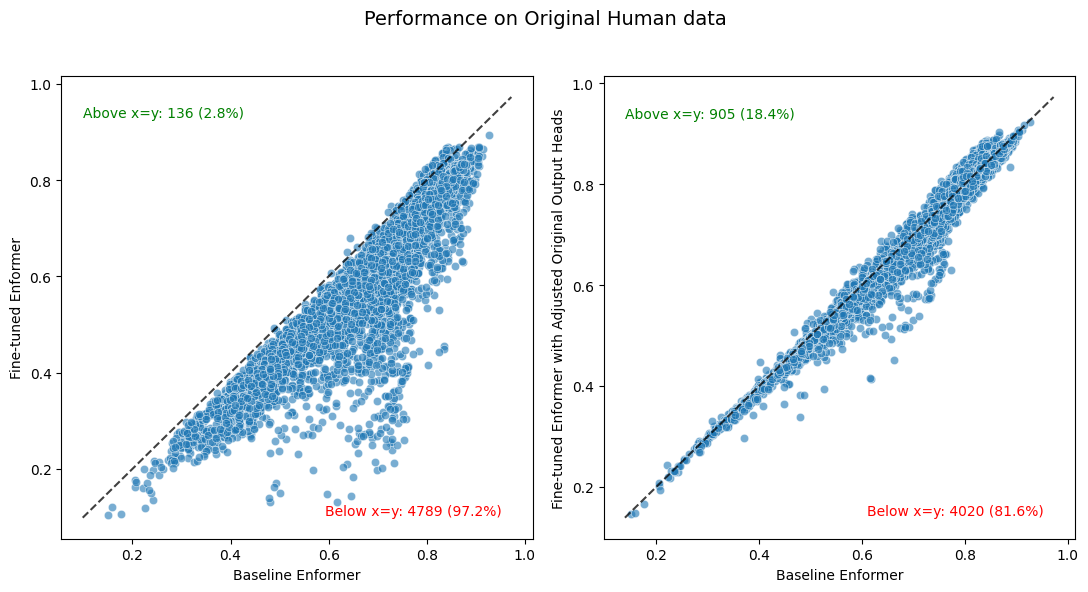

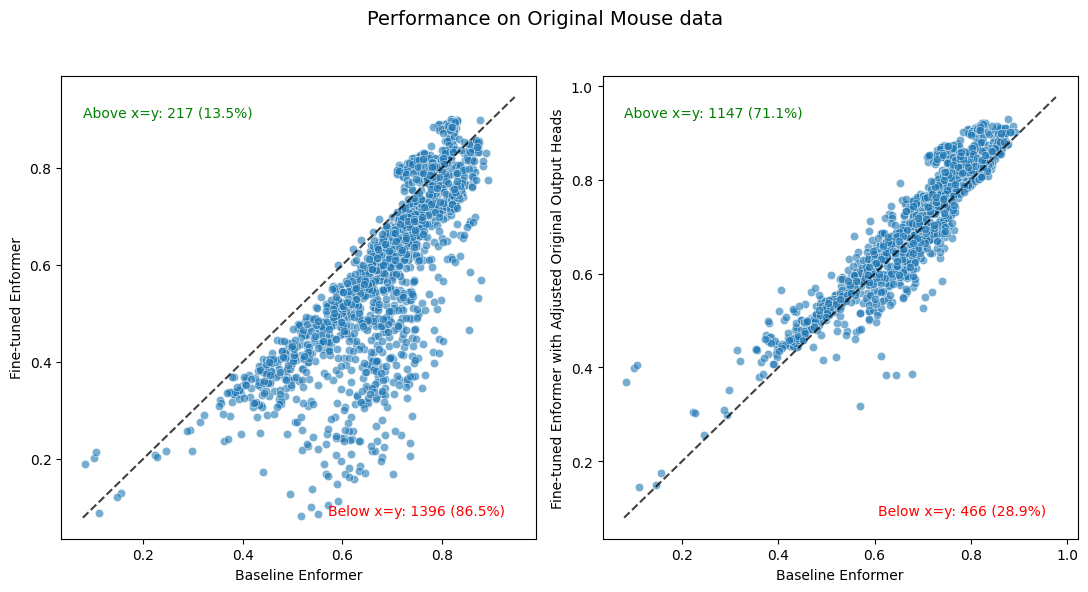

In [25]:
df = full_summary.copy()

# Define metrics and models
metrics = ["pearson_corr"]
fine_tuned_models = ["regression", "finetune_regression_on_enformer_data"]

# Get unique species
species_list = df["species"].unique()

model_to_name = {
    "regression": "Fine-tuned Enformer",
    "finetune_regression_on_enformer_data": "Fine-tuned Enformer with Adjusted Original Output Heads",
}
species_to_name = {"mouse": "Mouse", "human": "Human"}
metric_to_name = {"pearson_corr": "Pearson Correlation"}

# Loop over species and metrics
for species in ["human", "mouse"]:
    df_species = df[df["species"] == species]

    for metric in metrics:
        fig, axes = plt.subplots(1, 2, figsize=(11, 6))

        for i, model in enumerate(fine_tuned_models):
            ax = axes[i]

            # Merge baseline with fine-tuned models on track_name
            df_baseline = df_species[df_species["model"] == "baseline"].set_index(
                "track_name"
            )
            df_finetuned = df_species[df_species["model"] == model].set_index(
                "track_name"
            )

            df_merged = (
                df_baseline[[metric]]
                .rename(columns={metric: "baseline"})
                .merge(
                    df_finetuned[[metric]].rename(columns={metric: model}),
                    left_index=True,
                    right_index=True,
                )
                .reset_index()
            )

            # Scatterplot
            sns.scatterplot(x="baseline", y=model, data=df_merged, ax=ax, alpha=0.6)

            # Compute values above and below the x=y line
            above = (df_merged[model] > df_merged["baseline"]).sum()
            below = (df_merged[model] < df_merged["baseline"]).sum()
            total = len(df_merged)

            above_pct = 100 * above / total
            below_pct = 100 * below / total

            # Plot x=y line
            lims = [
                np.min([df_merged["baseline"].min(), df_merged[model].min()]) * 0.95,
                np.max([df_merged["baseline"].max(), df_merged[model].max()]) * 1.05,
            ]
            ax.plot(lims, lims, "k--", alpha=0.75)

            # Add text annotations
            ax.text(
                lims[0],
                lims[1] * 0.98,
                f"Above x=y: {above} ({above_pct:.1f}%)",
                ha="left",
                va="top",
                fontsize=10,
                color="green",
            )
            ax.text(
                lims[1] * 0.98,
                lims[0],
                f"Below x=y: {below} ({below_pct:.1f}%)",
                ha="right",
                va="bottom",
                fontsize=10,
                color="red",
            )

            ax.set_xlabel(f"Baseline Enformer")
            ax.set_ylabel(f"{model_to_name[model]}")

        plt.suptitle(
            f"Performance on Original {species_to_name[species]} data", fontsize=14
        )
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f"figures/fig_S10_{species}.pdf", dpi=600, bbox_inches="tight")
        plt.savefig(f"figures/fig_S10_{species}.svg", dpi=600, bbox_inches="tight")